In [60]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     TimeSeriesSplit,
                                     cross_val_score)

# Classifier
from xgboost import XGBClassifier, plot_importance, to_graphviz

# Metrics
from sklearn.metrics import (precision_recall_curve,
                             roc_curve,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay)
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             recall_score,
                             precision_score,
                             roc_auc_score,
                             auc)
from sklearn.metrics import (classification_report,
                             confusion_matrix)

In [4]:
# Load file
df = pd.read_csv('data/spy.csv', index_col=0, parse_dates=True)[['Adj Close']]

# Calculate returns
df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()
df.dropna(inplace=True)

# Output first five rows
df.head()

,Adj Close,Returns,Ret_1M
Date,,,
1928-01-31,17.570000,0.004564,-0.010756
1928-01-02,17.530001,-0.002279,-0.010780
1928-02-02,17.629999,0.005688,0.004548
1928-03-02,17.400000,-0.013132,-0.014832
1928-06-02,17.450001,0.002869,-0.002861


In [6]:
# Descriptive statistics
df.describe()

,Adj Close,Returns,Ret_1M
count,23953.000000,23953.000000,23953.000000
mean,586.438394,0.000230,0.004574
std,931.329592,0.012013,0.053578
min,4.400000,-0.228997,-0.548062
25%,24.510000,-0.004577,-0.019324
50%,101.500000,0.000480,0.009589
75%,965.539978,0.005442,0.033230
max,4796.560059,0.153661,0.479470


In [7]:
# Check for missing values
df.isnull().sum()

Adj Close    0
Returns      0
Ret_1M       0
dtype: int64

In [9]:
# Create features (predictors) list
features_list = []
for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

df.dropna(inplace=True)

In [17]:
# Define target
df['Target'] = np.where(df['Adj Close'].shift(-1) > 0.995*df['Adj Close'], 1, 0)
df = df[:-1]

# Check output
df

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,...,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,
1928-04-26,19.469999,0.007216,0.030242,0.003086,0.009348,0.024962,0.009637,0.030242,0.010300,0.043029,...,0.008761,0.129212,0.008331,0.110108,0.008616,0.109535,0.008294,0.107245,0.008214,1
1928-04-27,19.680000,0.010728,0.037799,-0.002537,0.008396,0.023131,0.009500,0.037799,0.010501,0.056441,...,0.008844,0.138772,0.008408,0.123133,0.008674,0.120836,0.008369,0.113410,0.008287,1
1928-04-30,19.750000,0.003551,0.024085,0.003551,0.008433,0.024604,0.009513,0.024085,0.009873,0.050361,...,0.008829,0.139408,0.008408,0.129561,0.008640,0.121524,0.008371,0.119240,0.008272,1
1928-01-05,19.780001,0.001518,0.044980,0.013232,0.007884,0.034983,0.009062,0.044980,0.008604,0.037604,...,0.008608,0.145008,0.008341,0.149108,0.008115,0.119617,0.008370,0.115069,0.008258,1
1928-02-05,19.830000,0.002525,0.041705,0.015756,0.007878,0.019863,0.008017,0.041705,0.008564,0.045920,...,0.008597,0.144615,0.008341,0.156928,0.008027,0.122712,0.008361,0.130726,0.008018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,4179.830078,-0.006127,0.014519,0.016872,0.008594,0.014619,0.007339,0.014519,0.008000,0.026227,...,0.007791,0.049610,0.007936,0.056158,0.008141,0.080702,0.008621,0.031944,0.009129,1
2023-01-06,4221.020020,0.009806,0.031348,0.014857,0.008350,0.019951,0.007643,0.031348,0.008027,0.039882,...,0.007866,0.060991,0.008030,0.053065,0.008062,0.074166,0.008456,0.057196,0.008961,1
2023-02-06,4282.370117,0.014430,0.053023,0.019887,0.009006,0.036079,0.008294,0.053023,0.008235,0.034935,...,0.008139,0.061284,0.008040,0.084095,0.007866,0.095601,0.008557,0.070212,0.009128,1


In [18]:
# Convert to numpy
X = df.drop(['Adj Close', 'Returns', 'Ret_1M', 'Target'], axis=1)
X.values

array([[ 0.00308637,  0.00934809,  0.02496224, ...,  0.00829429,
         0.10724548,  0.00821372],
       [-0.00253743,  0.00839641,  0.02313133, ...,  0.00836922,
         0.11340999,  0.00828726],
       [ 0.0035506 ,  0.00843306,  0.02460401, ...,  0.00837075,
         0.11923974,  0.00827171],
       ...,
       [ 0.01988654,  0.00900572,  0.03607908, ...,  0.00855687,
         0.07021176,  0.00912824],
       [ 0.01932786,  0.0090311 ,  0.03565805, ...,  0.00829486,
         0.08683802,  0.00876194],
       [ 0.02152397,  0.00900974,  0.03505538, ...,  0.00811687,
         0.10377312,  0.00850579]])

In [19]:
# Define label or target
y = df['Target']
y

Date
1928-04-26    1
1928-04-27    1
1928-04-30    1
1928-01-05    1
1928-02-05    1
             ..
2023-05-31    1
2023-01-06    1
2023-02-06    1
2023-05-06    1
2023-06-06    1
Name: Target, Length: 23892, dtype: int32

In [20]:
# Splitting the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Output the train and test data size
print(f'Train and Test Size: {len(X_train), len(X_test)}')

Train and Test Size: (19113, 4779)


In [21]:
# Scale and fit the classifier model
model = XGBClassifier(verbosity=0, silent=True, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [22]:
# Predicting the test dataset
y_pred = model.predict(X_test)

# Predict probabilities 
y_proba = model.predict_proba(X_test)

In [24]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.8706, Test Accuracy: 0.7548


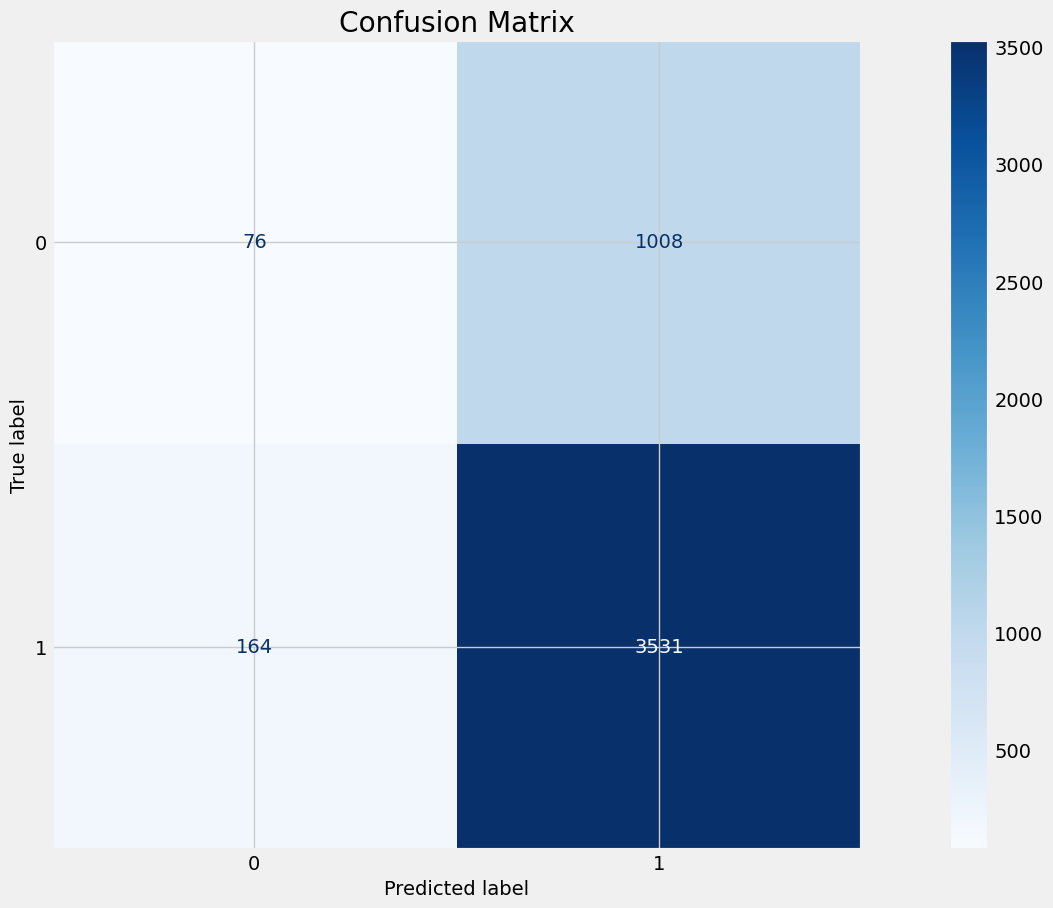

In [26]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model,
                                             X_test,
                                             y_test,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.07      0.11      1084
           1       0.78      0.96      0.86      3695

    accuracy                           0.75      4779
   macro avg       0.55      0.51      0.49      4779
weighted avg       0.67      0.75      0.69      4779



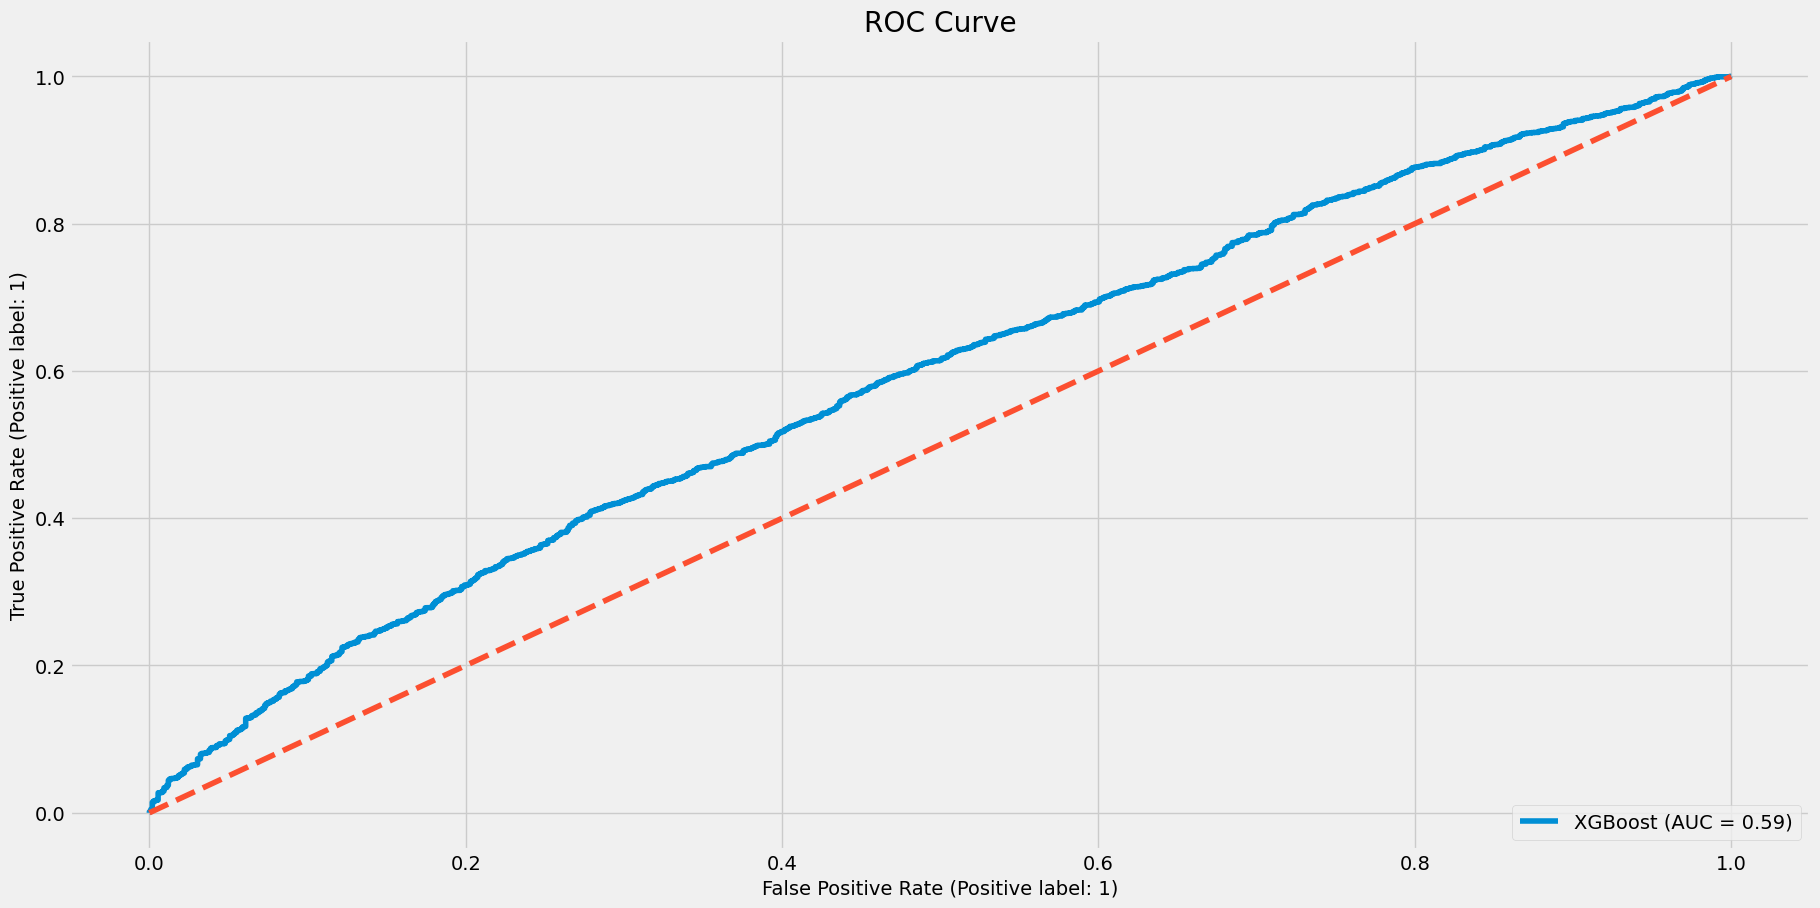

In [28]:
# Display Roc Curve
disp_roc = RocCurveDisplay.from_estimator(model,
                                          X_test,
                                          y_test,
                                          name='XGBoost')
plt.title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

In [29]:
# Time-Series CV 3-split
tscv = TimeSeriesSplit(n_splits=4, gap=1)
for train, test in tscv.split(X):
    print(train,test)

[   0    1    2 ... 4776 4777 4778] [4780 4781 4782 ... 9555 9556 9557]
[   0    1    2 ... 9554 9555 9556] [ 9558  9559  9560 ... 14333 14334 14335]
[    0     1     2 ... 14332 14333 14334] [14336 14337 14338 ... 19111 19112 19113]
[    0     1     2 ... 19110 19111 19112] [19114 19115 19116 ... 23889 23890 23891]


In [30]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

# Get params list
model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'silent': True}

In [31]:
# Hyper parameter optimization
param_grid = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
              'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
              'colsample_bytree': [0.3, 0.4, 0.5, 0.7]}

# Perform random search
rs = RandomizedSearchCV(model, param_grid, n_iter=100, scoring='f1', cv=tscv, verbose=0)
rs.fit(X_train, y_train, verbose=0)

# Best parameters
rs.best_params_

{'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.4,
 'colsample_bytree': 0.3}

In [32]:
# Best score
rs.best_score_

0.8786731751474596

In [34]:
# Refit the XGB Classifier with the best params
cls = XGBClassifier(**rs.best_params_)

cls.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-logloss:0.54802	validation_1-logloss:0.53668
[1]	validation_0-logloss:0.54632	validation_1-logloss:0.53524
[2]	validation_0-logloss:0.54478	validation_1-logloss:0.53399
[3]	validation_0-logloss:0.54330	validation_1-logloss:0.53277
[4]	validation_0-logloss:0.54195	validation_1-logloss:0.53168
[5]	validation_0-logloss:0.54074	validation_1-logloss:0.53071
[6]	validation_0-logloss:0.53969	validation_1-logloss:0.52985
[7]	validation_0-logloss:0.53864	validation_1-logloss:0.52906
[8]	validation_0-logloss:0.53770	validation_1-logloss:0.52828
[9]	validation_0-logloss:0.53686	validation_1-logloss:0.52768
[10]	validation_0-logloss:0.53604	validation_1-logloss:0.52704
[11]	validation_0-logloss:0.53527	validation_1-logloss:0.52629
[12]	validation_0-logloss:0.53460	validation_1-logloss:0.52576
[13]	validation_0-logloss:0.53396	validation_1-logloss:0.52524
[14]	validation_0-logloss:0.53340	validation_1-logloss:0.52482
[15]	validation_0-logloss:0.53286	validation_1-logloss:0.52437
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
# Return the evaluation results
eval_results = cls.evals_result()
eval_results

{'validation_0': OrderedDict([('logloss',
               [0.5480228480071879,
                0.5463152634665898,
                0.544776879082992,
                0.5432987019738541,
                0.5419535241549015,
                0.540736556991842,
                0.5396892226917094,
                0.538637218659398,
                0.5377041310436814,
                0.536860583495172,
                0.5360445762715335,
                0.5352678370201026,
                0.5345966828718905,
                0.5339589580470174,
                0.5334022632949001,
                0.5328604415872249,
                0.5323323841054555,
                0.531847537186022,
                0.5313987474303252,
                0.5309232714155845,
                0.5305383738855587,
                0.5301645390156493,
                0.5297797348726265,
                0.5294159721687014,
                0.5291107420866626,
                0.5287781227558379,
                0.528479306

In [36]:
# Cross validation score
score = cross_val_score(cls, X_train, y_train, cv=tscv)
print(f'Mean CV Score: {score.mean():0.4}')

Mean CV Score: 0.7841


Text(0.5, 1.0, 'Features Importance')

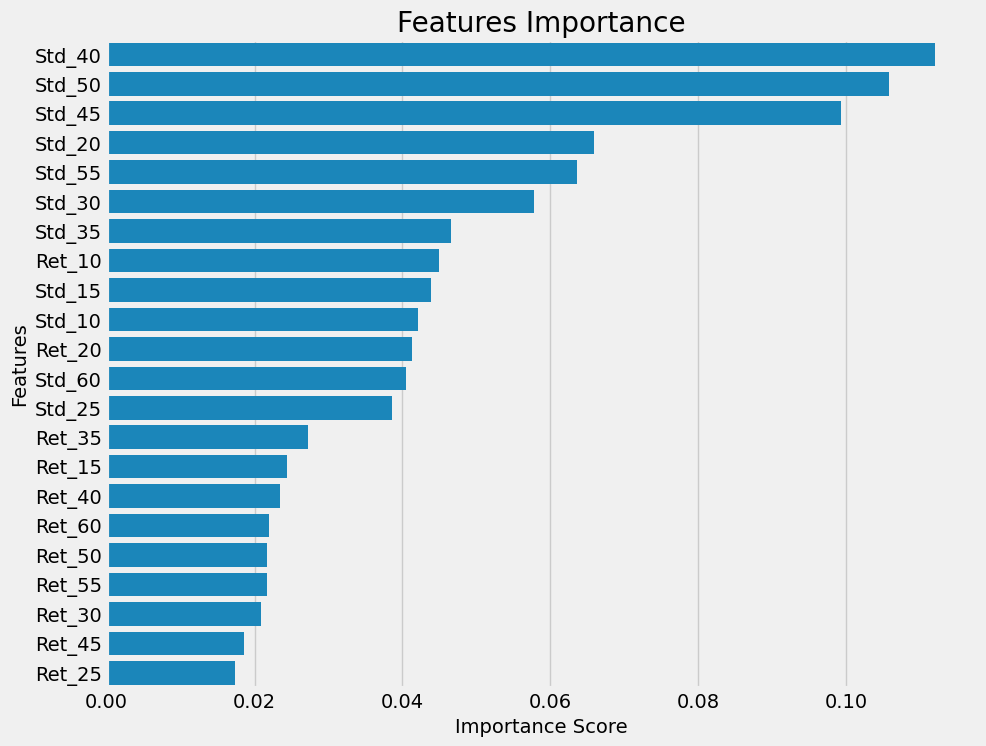

In [37]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
feature_imp = pd.DataFrame({'Importance Score': cls.feature_importances_, 
                            'Features': X.columns}).sort_values(by='Importance Score', ascending=False)

sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance')

In [38]:
# The gain is the most relevant attribute to interpret the relative importance of each feature
plot_importance?

Signature:
plot_importance(
    booster: Union[xgboost.sklearn.XGBModel, xgboost.core.Booster, dict],
    ax: Optional[Any] = None,
    height: float = 0.2,
    xlim: Optional[tuple] = None,
    ylim: Optional[tuple] = None,
    title: str = 'Feature importance',
    xlabel: str = 'F score',
    ylabel: str = 'Features',
    fmap: Union[str, os.PathLike] = '',
    importance_type: str = 'weight',
    max_num_features: Optional[int] = None,
    grid: bool = True,
    show_values: bool = True,
    values_format: str = '{v}',
    **kwargs: Any,
) -> Any
Docstring:
Plot importance based on fitted trees.

Parameters
----------
booster :
    Booster or XGBModel instance, or dict taken by Booster.get_fscore()
ax : matplotlib Axes
    Target axes instance. If None, new figure and axes will be created.
grid :
    Turn the axes grids on or off.  Default is True (On).
importance_type :
    How the importance is calculated: either "weight", "gain", or "cover"

    * "weight" is the number of times

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

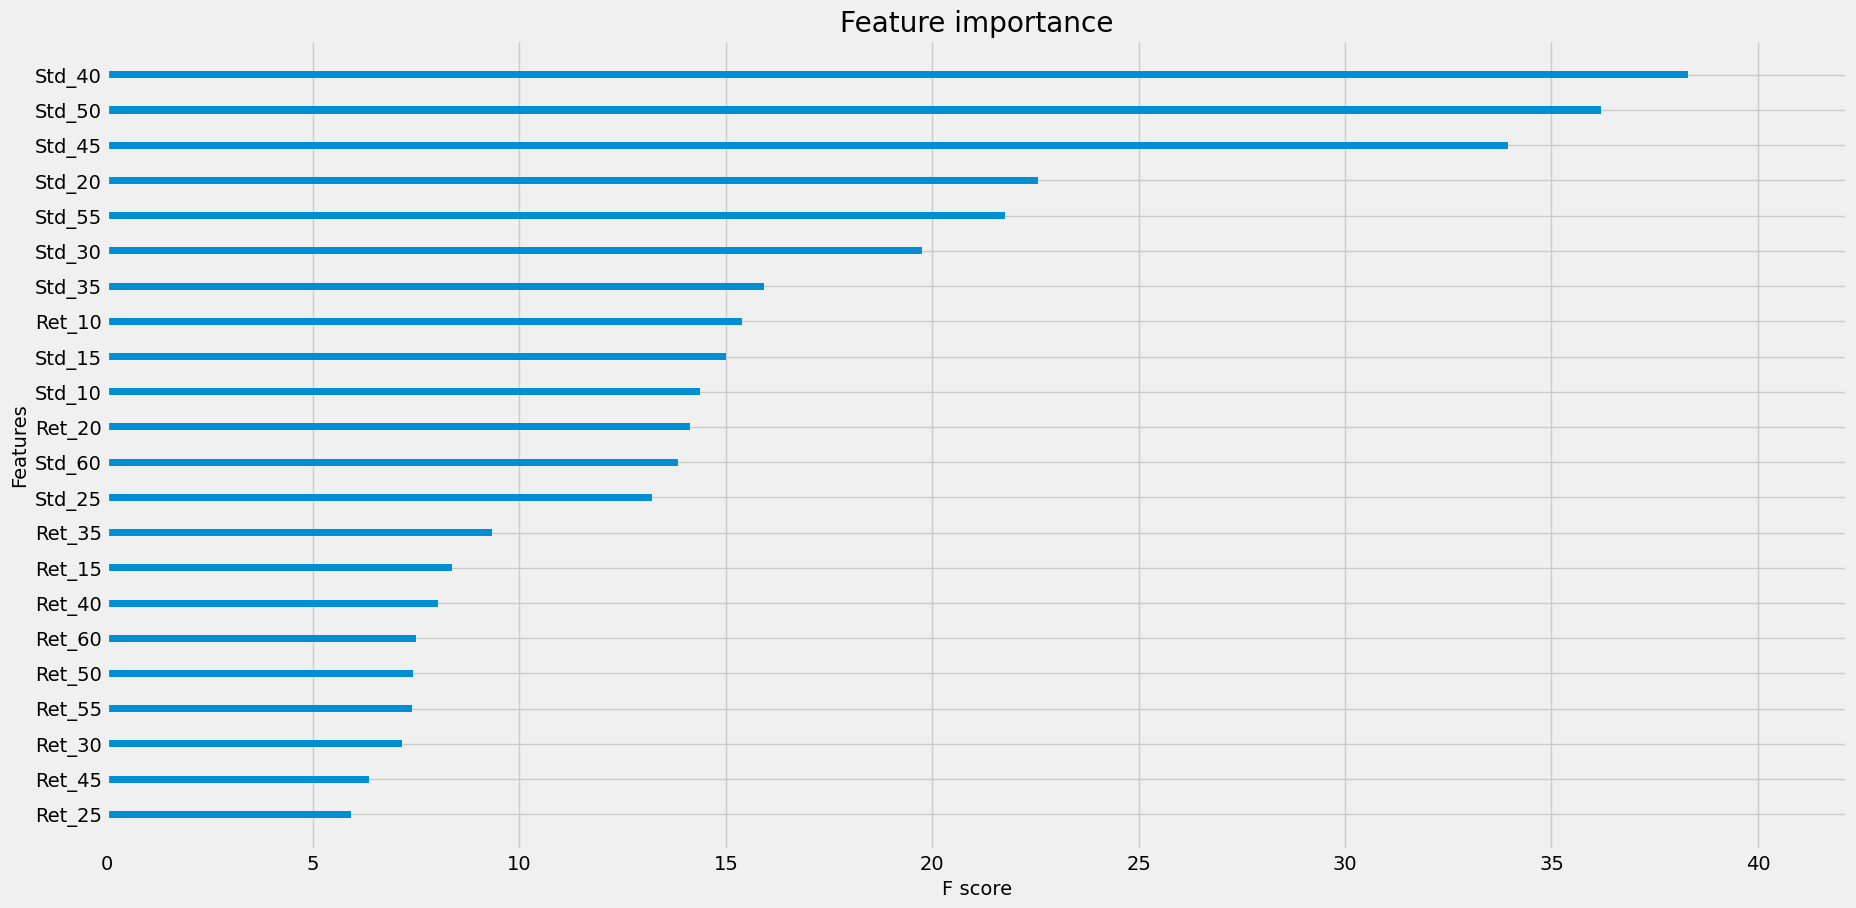

In [39]:
# Feature importance_type='gain'
plot_importance(cls, importance_type='gain', show_values=False)

In [40]:
import shap
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_test)

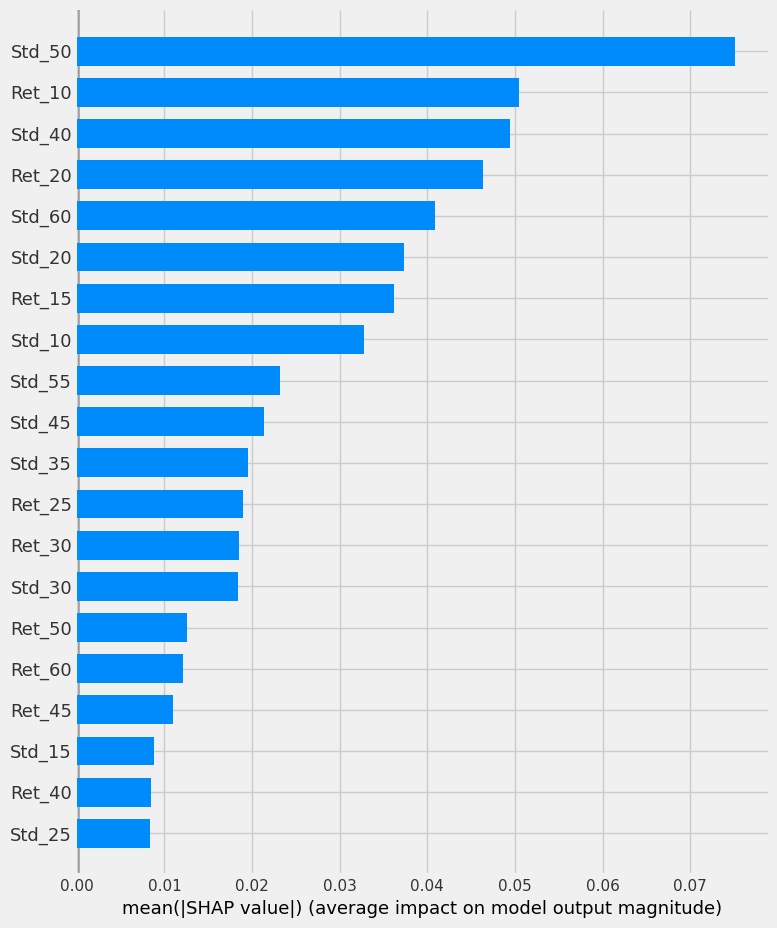

In [41]:
# Feature importance summary
shap.summary_plot(shap_values, X_test, plot_type='bar')

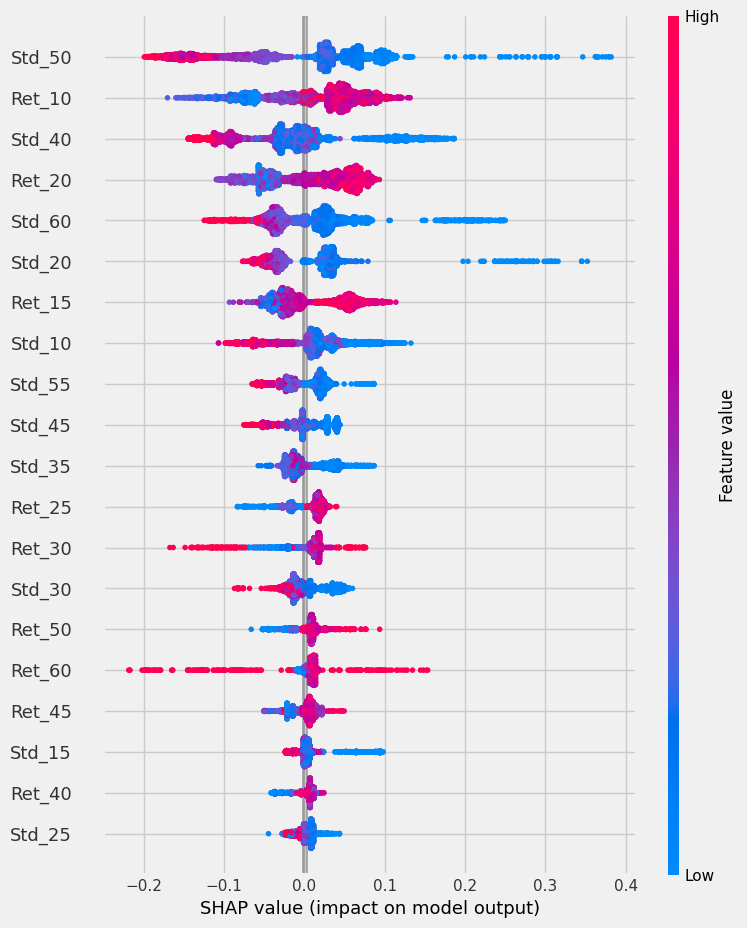

In [42]:
# Interpretation plot
shap.summary_plot(shap_values, X_test)

In [63]:
# Tree visualization
# change tree number to see the corresponding plot
to_graphviz(cls, num_trees=10, rankdir='UT')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [56]:
# Predicting the test dataset
y_pred = cls.predict(X_test)

# Measure accuracy
acc_train = accuracy_score(y_train, cls.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

# Print accuracy
print(f'\n Training Accuracy \t: {acc_train:0.4} \n Test Accuracy \t\t: {acc_test:0.4}')


 Training Accuracy 	: 0.7621 
 Test Accuracy 		: 0.7732


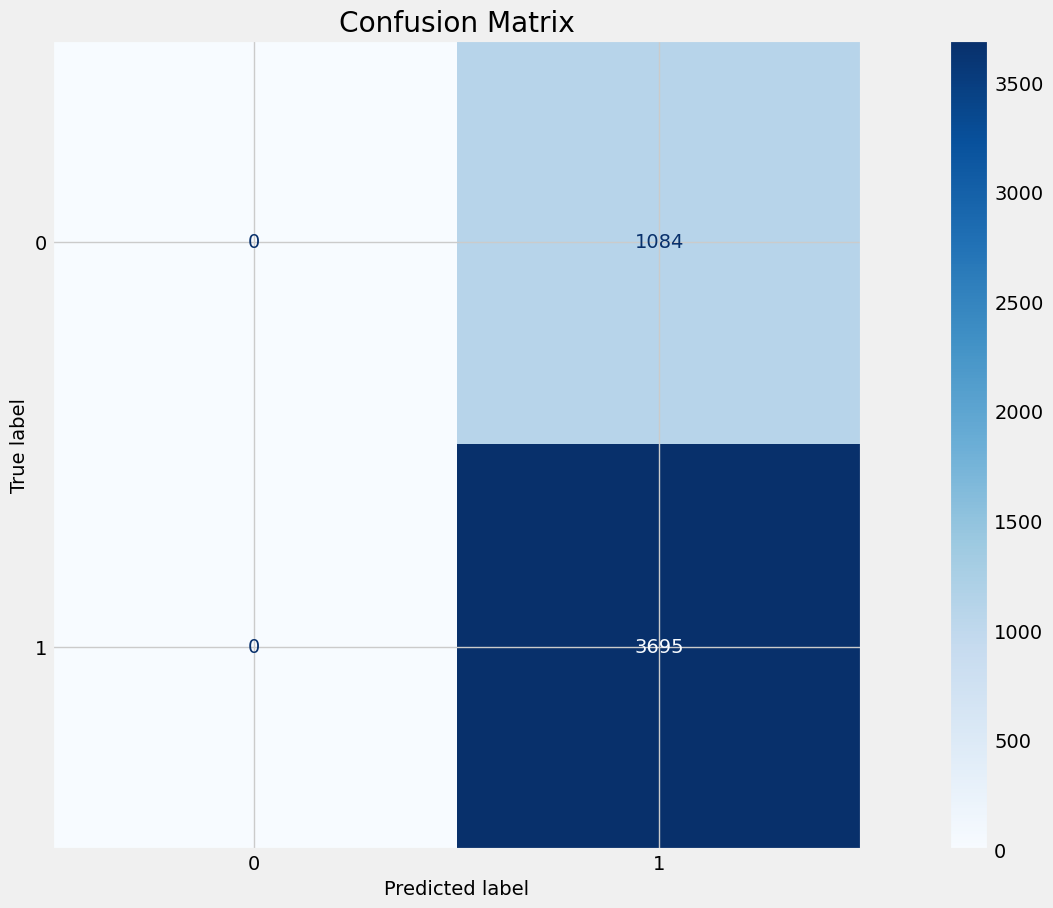

In [57]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(cls, 
                                             X_test,
                                             y_test,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [58]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1084
           1       0.77      1.00      0.87      3695

    accuracy                           0.77      4779
   macro avg       0.39      0.50      0.44      4779
weighted avg       0.60      0.77      0.67      4779



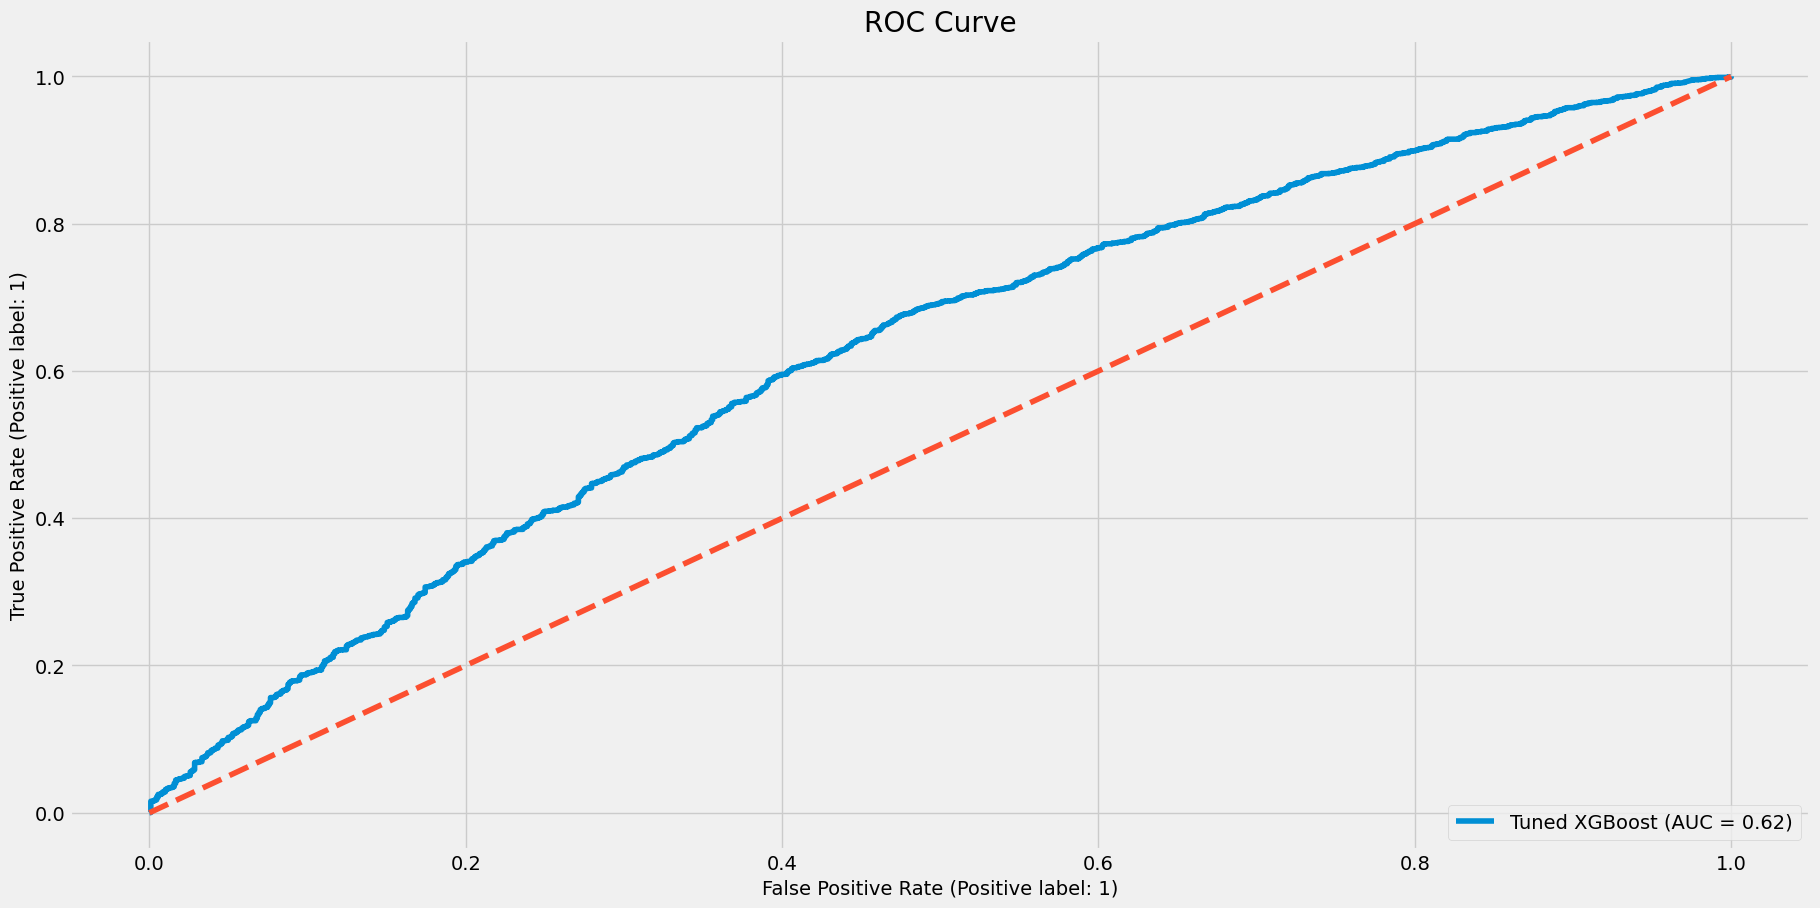

In [59]:
# Display ROC Curve
disp_roc = RocCurveDisplay.from_estimator(cls,
                                          X_test,
                                          y_test,
                                          name='Tuned XGBoost')
plt.title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()